# Abstract

1. Dataset Statistcial Analysis

2. Feature preprocessing and engineering

3. LSTM with Attention and Guassian Noise

4. Model insample Training and test out of sample data




In [1]:
import pandas as pd, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
temp = dict(layout = go.Layout(font = dict(family="Franklin Gothic", size=12), width = 1500))

import torch
from torch import tensor
from torch import nn
import torch.nn.init as init
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn.functional as F
import time


In [2]:
import zipfile

with zipfile.ZipFile(r'/content/train.csv.zip', 'r') as z:
    with z.open('train.csv') as f:
        df = pd.read_csv(f)

with zipfile.ZipFile(r'/content/test.csv.zip', 'r') as z1:
    with z1.open('test.csv') as f1:
        test_df = pd.read_csv(f1)

# Specific Feature Factor meaning:
prediction variable:

target - The 60 second future move in the wap of the stock.

feature factors:

wap - The weighted average price in the non-auction book.
seconds_in_bucket - The number of seconds elapsed since the beginning of the day's closing auction, always starting from 0.
imbalance_buy_sell_flag - An indicator reflecting the direction of auction imbalance.
reference_price - The price at which paired shares are maximized, the imbalance is minimized and the distance from the bid-ask midpoint is minimized, in that order. Can also be thought of as being equal to the near price bounded between the best bid and ask price.
far_price - The crossing price that will maximize the number of shares matched based on auction interest only. This calculation excludes continuous market orders.
Near_price - The crossing price that will maximize the number of shares matched based auction and continuous market orders.



In [3]:
df.head(-5)
test_df.shape

(33000, 17)

In [4]:
df.info

<bound method DataFrame.info of          stock_id  date_id  seconds_in_bucket  imbalance_size  \
0               0        0                  0      3180602.69   
1               1        0                  0       166603.91   
2               2        0                  0       302879.87   
3               3        0                  0     11917682.27   
4               4        0                  0       447549.96   
...           ...      ...                ...             ...   
5237975       195      480                540      2440722.89   
5237976       196      480                540       349510.47   
5237977       197      480                540            0.00   
5237978       198      480                540      1000898.84   
5237979       199      480                540      1884285.71   

         imbalance_buy_sell_flag  reference_price  matched_size  far_price  \
0                              1         0.999812   13380276.64        NaN   
1                             -

In [5]:
def inspect_columns(df):

    result = pd.DataFrame({
        'unique': df.nunique() == len(df),
        'cardinality': df.nunique(),
        'with_null': df.isna().any(),
        'null_pct': round((df.isnull().sum() / len(df)) * 100, 2),
        '1st_row': df.iloc[0],
        'random_row': df.iloc[np.random.randint(low=0, high=len(df))],
        'last_row': df.iloc[-1],
        'dtype': df.dtypes
    })
    return result

inspect_columns(df)

,unique,cardinality,with_null,null_pct,1st_row,random_row,last_row,dtype
stock_id,False,200,False,0.00,0,187,199,int64
date_id,False,481,False,0.00,0,347,480,int64
seconds_in_bucket,False,55,False,0.00,0,50,540,int64
imbalance_size,False,2971863,True,0.00,3180602.69,12910897.37,1884285.71,float64
imbalance_buy_sell_flag,False,3,False,0.00,1,1,-1,int64
reference_price,False,28741,True,0.00,0.999812,0.999781,1.002129,float64
matched_size,False,2948862,True,0.00,13380276.64,22677266.33,24073677.32,float64
far_price,False,95739,True,55.26,NaN,NaN,1.000859,float64
near_price,False,84625,True,54.55,NaN,NaN,1.001494,float64
bid_price,False,28313,True,0.00,0.999812,0.999532,1.002129,float64


# conclusion:
The dataset contains a mix of continuous numerical features such as prices and sizes, categorical features such as stock_id and imbalance_buy_sell_flag, and temporal features such as date_id and seconds_in_bucket. The presence of null values in some columns such as far_price, near_price suggests that not all information is available for every time interval. The target column is used for predictive modeling, for forecasting stock market-related outcomes.

## EDA

<ipython-input-6-0058caf9bd35>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(df['target'])


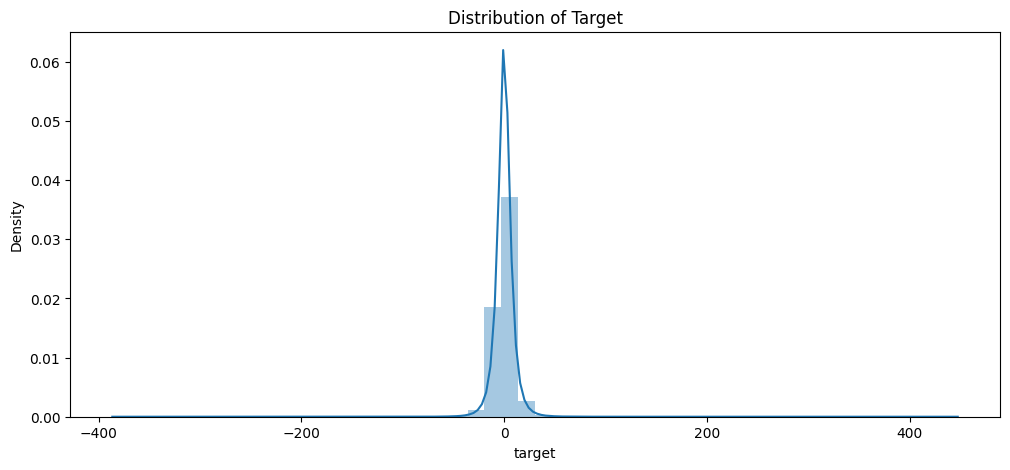

In [6]:
plt.figure(figsize=(12,5))
plt.title("Distribution of Target")
ax = sns.distplot(df['target'])

# Conclusion:
the target varaible shows approximately normal distributed and most of the target is clusted at 0, indicating target is neutral.

The target distribution shows symmetric, which suggests that the target variable has a relatively even spread around the mean value.

The long tails stretching to both the left and the right indicate the presence of outliers or extreme values in the target variable.

Compare to normal distribution, target distribution has more values around the mean and more outliers.

<ipython-input-7-054bdb9bdbb0>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr=df.corr()


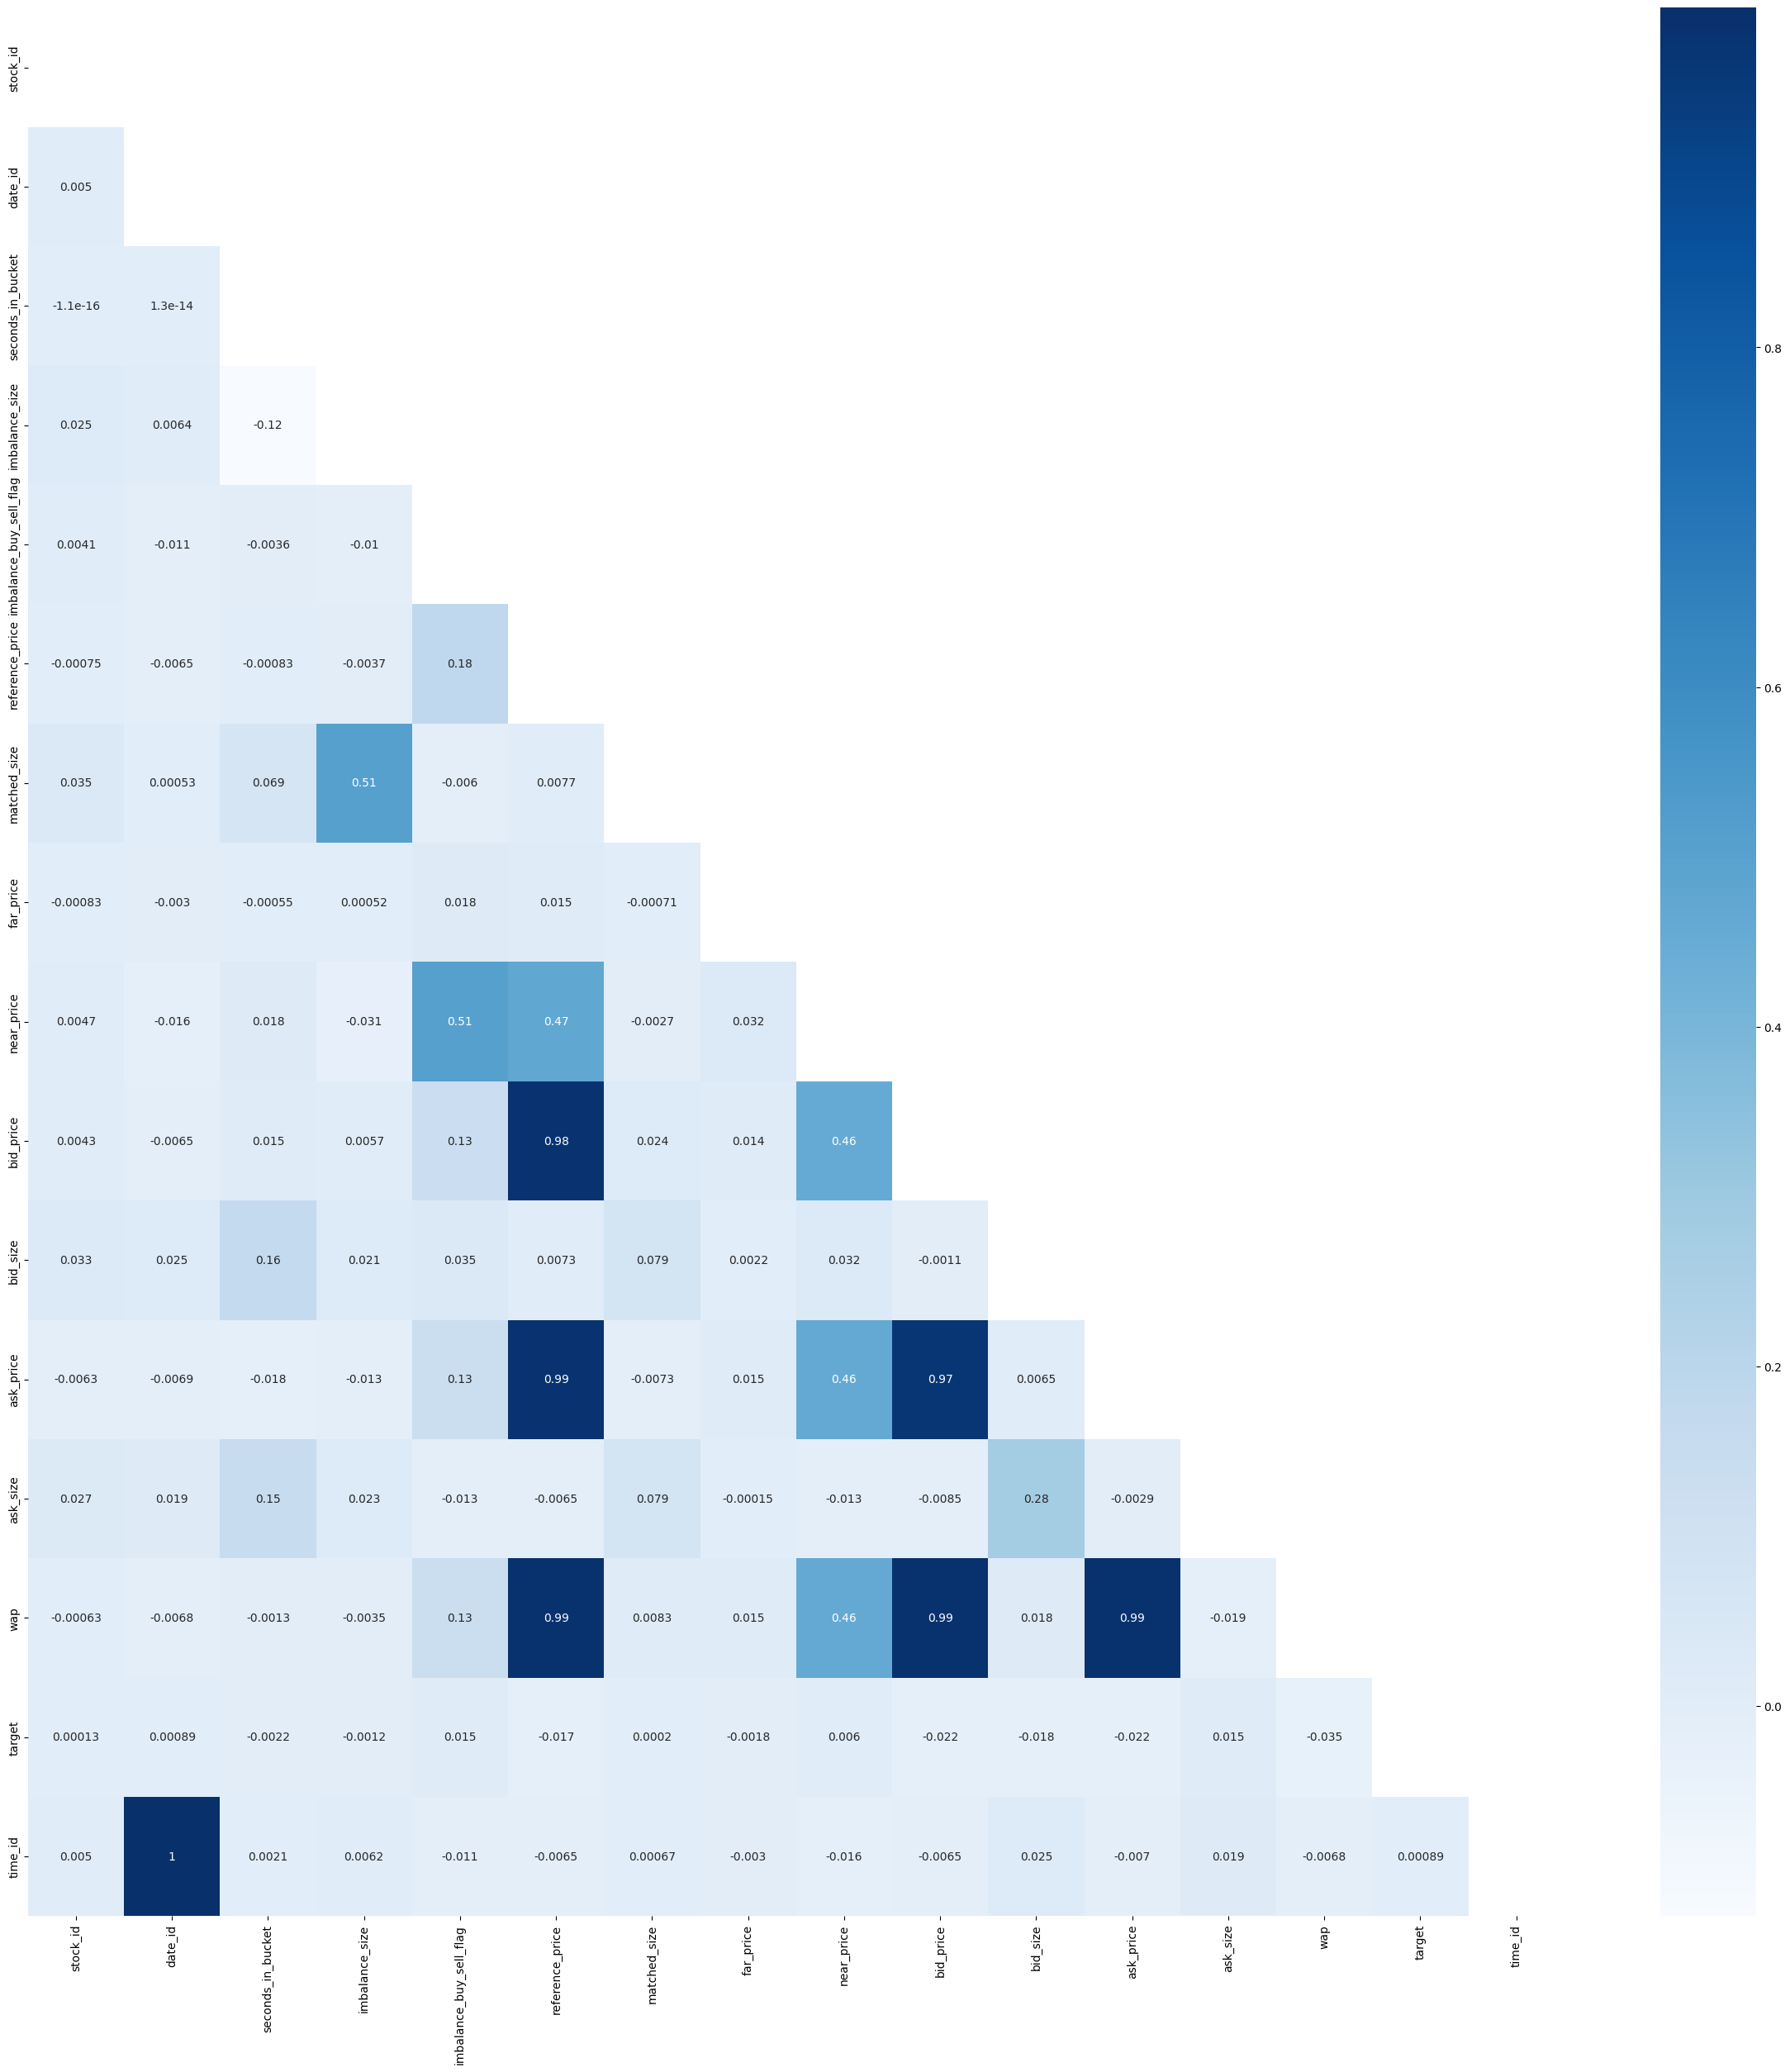

In [7]:
plt.figure(figsize=(30,30))
corr=df.corr()
sns.heatmap(corr,annot=True,cmap='Blues',mask=np.triu(corr))
plt.show()

# Conclusion:
The correlation among each variables show that reference price have high linear correlation with wap, ask_price and bid_price, and as wage is derived from bdid price and ask price, they have high linear correlationship. Other than that, features are almost independent with others.

Target data is highly related to date_id shows that it is a time series data.
Target is relatively highly linear related with bid size and ask size  than other factors.

In [8]:
stock_id_0_df = df[df['stock_id'] == 0].head(700)
stock_id_0_df

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
191,0,0,10,1299772.70,1,1.000026,15261106.63,NaN,NaN,0.999812,13996.50,1.000026,23519.16,0.999892,0.389814,1,0_10_0
382,0,0,20,1299772.70,1,0.999919,15261106.63,NaN,NaN,0.999812,4665.50,0.999919,12131.60,0.999842,4.220009,2,0_20_0
573,0,0,30,1299772.70,1,1.000133,15261106.63,NaN,NaN,1.000026,55998.00,1.000133,46203.30,1.000085,5.450249,3,0_30_0
764,0,0,40,1218204.43,1,1.000455,15342674.90,NaN,NaN,1.000241,14655.95,1.000455,26610.45,1.000317,3.169775,4,0_40_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133220,0,12,350,2971492.85,-1,0.999836,11139572.93,0.982113,0.991391,0.999836,5850.51,1.000044,52761.50,0.999856,1.089573,695,12_350_0
133412,0,12,360,2971492.85,-1,0.999836,11139572.93,0.982113,0.990974,0.999731,20714.40,0.999836,671.37,0.999832,1.599789,696,12_360_0
133604,0,12,370,2962188.05,-1,0.999731,11139572.93,0.982113,0.991183,0.999731,25797.10,0.999940,56688.72,0.999796,0.170469,697,12_370_0
133796,0,12,380,2914225.16,-1,0.999523,11187535.82,0.982635,0.991391,0.999523,9779.76,0.999731,77103.60,0.999546,3.679991,698,12_380_0


In [9]:
# if the picture is no shown, it is picture1 in attach file

fig = go.Figure()

fig.add_trace(
    go.Scatter(x = stock_id_0_df['time_id'],
            y = stock_id_0_df['ask_price'],
            name = 'ask price',
            line = dict(color = 'blue')))

fig.add_trace(
    go.Scatter(x = stock_id_0_df['time_id'],
            y = stock_id_0_df['bid_price'],
            name = 'bid price',
            line = dict(color = 'green')))


fig.update_layout(title = "Overview for Ask Price and Bid Price",
                title_font = dict(size = 15),
                showlegend = True,
                width = 1000,
                height = 400,
                margin = dict(l = 40, r = 40, t = 40, b = 20))

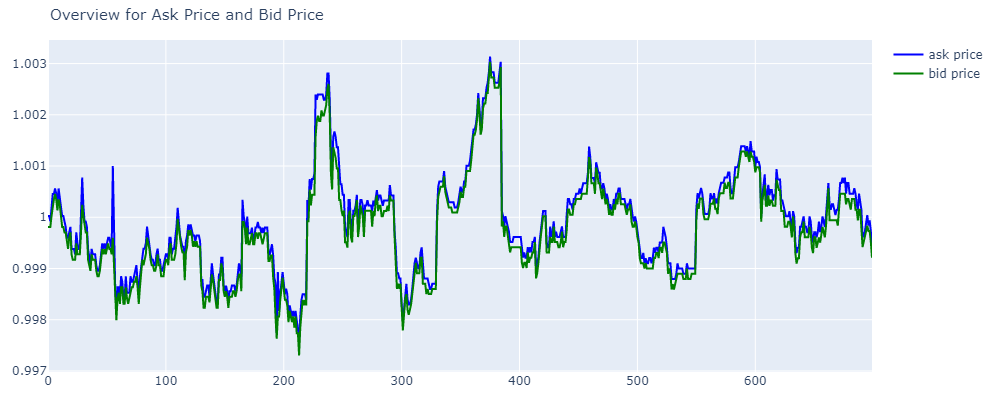

# Conclusion
This shows close interactive relationshipt between ask price and bid price. The Both ask and bid prices move together closely, suggesting less volatility. This implies the target variables cluster at 0, as the difference between bid price and ask price are small. Also, time step at around 220 and 370 are highly volatile.

In [10]:
# if the picture is no shown, it is picture2 in attach file

fig = go.Figure()

fig.add_trace(
    go.Scatter(x = stock_id_0_df['time_id'],
            y = stock_id_0_df['target'],
            name = 'Target variable',
            line = dict(color = 'red'),
            yaxis = "y2"))

fig.add_trace(
    go.Scatter(x = stock_id_0_df['time_id'],
            y = stock_id_0_df['wap'],
            name = 'WAP',
            line = dict(color = 'black')))

fig.update_layout(title = "Overview for WAP and Target Variable",
                title_font = dict(size = 15),
                showlegend = True,
                width = 1000,
                height = 400,
                margin = dict(l = 40, r = 40, t = 40, b = 20),
                yaxis2 = dict(title = "Target Variable", overlaying = "y", side = "right"),)

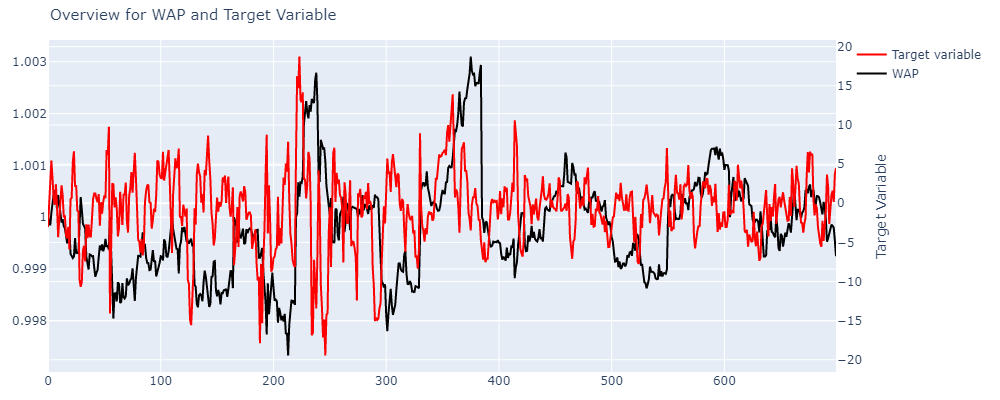

# Conclusion:

WAP, Weighted Average Price: Shown in black, this line represents the weighted average price of a financial instrument over a certain period. In financial markets, WAP is commonly used to give an average price for a security that accounts for both the volume and price of transactions. Typically, a higher volume of trades at a certain price level will have a greater influence on the WAP.

Target Variable: Shown in red, this line represents a target variable, its wide range and the way it oscillates might represent some form of residual, error, or differential value rather than a price or volume directly.

WAP and target have similar trends. WAP has a lag relative to target, because when target has a peak or a trough, WAP will have a similar situation later. Target is more volatile than WAP.




## Model: LSTM with Attention and Guassian Noise

In [11]:
def add_historic_features(df, cols, shifts=3, add_first=True):
    for col in cols:
        grouped_vals = df[["stock_id", "date_id", col]].groupby(["stock_id","date_id"])
        fill_value = df[col].mean()

        for shift in np.arange(shifts):
            df[col+"_shift"+str(shift+1)] = grouped_vals.shift(shift+1).fillna(fill_value)

        if add_first:
            df = df.merge(grouped_vals.first().reset_index(), on=["date_id","stock_id"], suffixes=["","_first"])
    return df

In [12]:
def fillmedian(df, cols):
    for col in cols:
        med_val = df[col].median()
        df[col] = df[col].fillna(med_val)
    return df

# Feature Engineering

The goal is to uncover relationships and patterns that are not immediately apparent in the raw data, which increase the prediction accuracy. Here, I mainly capture the imbalance between order size and different prices to measure supply and demand pressure on the amount and price of stock index. Specifically, imbalances contain information about market participants' expectations and intentions. A large imbalance with more buy orders than sell orders, this could indicate upward pressure on the price as buyers are more aggressive.  When considering relative movement, price imbalances might not only indicate the direction but also the potential relative magnitude of the price change. A large imbalance could suggest a more substantial price move compared to a smaller imbalance. Price imbalances can also reflect the liquidity of the market. In a liquid market, imbalances might be quickly resolved with minimal price impact. However, in less liquid markets, even a small imbalance can result in significant price movements.
 Train model how trades and order flows influence price changes to predict short-term price movements, because 

imb_ordersize:
Since the taget is linear related more with bid size and ask size, create Imbalance Order Size represents the relative difference between the bid size and ask size, the denominator is used to scale down the original size of bid size and ask size. In financial aspect, a high imbalance could indicate a potential movement in price, as a larger number of bids compared to asks could push the price up, and vice versa.

imb_match:
Since the target is more linear related to size, create Imbalance Match Size compares the size of imbalances to the size of matched trades. This could be indicative of the pressure on the price movement due to unmatched orders.

Since the target is derived from WAP, and WAP is derived from price size and price value, we add features to consider price movements to capture price movement patterns, which help to predict the future price movements.

Price Imbalances between different price pairs:
represent the normalized difference between pairs of prices, indicating the price . They could indicate the relative spread and potential arbitrage opportunities between different prices, which can be a signal for market inefficiencies or pricing errors.

Price imbalances among 3 different unique prices:
identify patterns that occur when one price is significantly different from the others, potentially signaling unusual market conditions or opportunities.

# missing value

Assign neutral value that represents a no-change situation or a baseline value to features vary between 0 to 1.

Assign median to fill in missing values for the 'imbalance_size' and 'matched_size' to estimate typical trade sizes without being skewed by extremely large or small values.






In [13]:
def generate_features(raw_df):
    df1 = raw_df.copy()

    df1[["reference_price", "far_price","near_price","bid_price","ask_price","wap"]] = df1[["reference_price", "far_price","near_price","bid_price","ask_price","wap"]].fillna(1.0)
    df1 = fillmedian(df1, ["imbalance_size", "matched_size"])

    df1['imb_ordersize'] = df1.eval('(bid_size-ask_size)/(bid_size+ask_size)')
    df1['imb_match'] = df1.eval('(imbalance_size-matched_size)/(matched_size+imbalance_size)')

    # df1 = add_historic_features(df1, ["wap","matched_size"], shifts=6, add_first=True) # RAM too small to add in thses historical features

    features = [c for c in df1.columns if c not in ['stock_id', 'row_id', 'time_id', 'date_id', 'target']]

    prices = ['reference_price','far_price', 'near_price', 'ask_price', 'bid_price', 'wap']

    for i,a in enumerate(prices):
        for j,b in enumerate(prices):
            if i>j:
                df1[f'{a}_{b}_imb'] = df1.eval(f'({a}-{b})/({a}+{b})')
                features.append(f'{a}_{b}_imb')

    for i,a in enumerate(prices):
        for j,b in enumerate(prices):
            for k,c in enumerate(prices):
                if i>j and j>k:
                    max_ = df1[[a,b,c]].max(axis=1)
                    min_ = df1[[a,b,c]].min(axis=1)
                    mid_ = df1[[a,b,c]].sum(axis=1)-min_-max_

                    df1[f'{a}_{b}_{c}_imb2'] = (max_-mid_)/(mid_-min_)
                    features.append(f'{a}_{b}_{c}_imb2')

    return df1[features]

Make sure to fill every na and infinite values for LSTM model prperly operates later.

In [14]:
df1 = generate_features(df)

nullsum = df1.isna().sum(axis=0)
print(nullsum[nullsum != 0])

df1.dropna(inplace=True)

df1.reset_index(drop=True, inplace=True)

df1 = df1.apply(lambda x: x.replace([np.inf, -np.inf], x.median()) if np.isinf(x).any() else x)

df1

imb_ordersize                                    87
near_price_far_price_reference_price_imb2    280024
ask_price_far_price_reference_price_imb2      90241
ask_price_near_price_reference_price_imb2    102232
ask_price_near_price_far_price_imb2           95096
bid_price_far_price_reference_price_imb2      77584
bid_price_near_price_reference_price_imb2     87372
bid_price_near_price_far_price_imb2           82316
bid_price_ask_price_reference_price_imb2        220
bid_price_ask_price_far_price_imb2              220
bid_price_ask_price_near_price_imb2             220
wap_far_price_reference_price_imb2             1352
wap_near_price_reference_price_imb2            1369
wap_near_price_far_price_imb2                 97539
wap_ask_price_reference_price_imb2             1765
wap_ask_price_far_price_imb2                    475
wap_ask_price_near_price_imb2                   481
wap_bid_price_reference_price_imb2             1840
wap_bid_price_far_price_imb2                    507
wap_bid_pric

,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,...,wap_far_price_reference_price_imb2,wap_near_price_reference_price_imb2,wap_near_price_far_price_imb2,wap_ask_price_reference_price_imb2,wap_ask_price_far_price_imb2,wap_ask_price_near_price_imb2,wap_bid_price_reference_price_imb2,wap_bid_price_far_price_imb2,wap_bid_price_near_price_imb2,wap_bid_price_ask_price_imb2
0,10,1299772.70,1,1.000026,15261106.63,1.000000,1.000000,0.999812,13996.50,1.000026,...,2.407407e-01,2.407407e-01,0.000000e+00,0.000000e+00,2.407407e-01,2.407407e-01,1.675000e+00,1.350000,1.350000,1.675000
1,10,165923.20,-1,0.999955,1642894.96,1.000000,1.000000,0.999896,3743.52,1.000660,...,1.500000e+00,1.500000e+00,8.223874e-12,3.816667e+01,2.444444e+01,2.444444e+01,3.050847e-01,0.350649,0.350649,8.922078
2,10,184766.21,-1,0.999561,1937481.68,1.000000,1.000000,0.999403,37956.00,1.000298,...,6.605923e-01,6.605923e-01,-1.306044e+12,1.097394e-02,2.758621e-02,2.758621e-02,4.613924e+00,0.485762,0.485762,0.009019
3,10,10874033.58,-1,0.999870,19433394.31,1.000000,1.000000,0.999870,464.92,1.000042,...,2.066667e+01,2.066667e+01,0.000000e+00,2.766667e+01,3.387097e-01,3.387097e-01,1.130435e+00,20.666667,20.666667,27.666667
4,10,417742.24,-1,1.000154,17890422.68,1.000000,1.000000,1.000154,28799.28,1.000431,...,1.194805e+00,1.194805e+00,1.522217e+12,5.054348e-01,2.751479e-01,2.751479e-01,-4.143312e+11,1.194805,1.194805,0.505435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4827647,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,...,1.886792e-02,1.886792e-02,5.350276e+12,9.636364e+00,1.784512e-01,1.784512e-01,1.130435e+00,0.018868,0.018868,9.636364
4827648,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,...,3.424125e-01,6.848249e-01,1.684825e+00,4.602273e-01,1.173913e-01,1.870670e-01,7.926335e+11,0.342412,0.684825,0.460227
4827649,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,...,7.727273e-01,7.763158e-01,2.512461e-01,1.075000e+01,1.075000e+01,1.075000e+01,1.130435e+00,1.196072,1.219858,10.750000
4827650,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,...,-1.099231e-12,-1.099231e-12,-1.099231e-12,-1.099231e-12,-1.099231e-12,-1.099231e-12,5.315789e+00,5.315789,5.315789,5.315789


In [16]:
np.isinf(df1).any()
# df1.isnull().any()

seconds_in_bucket                            False
imbalance_size                               False
imbalance_buy_sell_flag                      False
reference_price                              False
matched_size                                 False
far_price                                    False
near_price                                   False
bid_price                                    False
bid_size                                     False
ask_price                                    False
ask_size                                     False
wap                                          False
imb_ordersize                                False
imb_match                                    False
far_price_reference_price_imb                False
near_price_reference_price_imb               False
near_price_far_price_imb                     False
ask_price_reference_price_imb                False
ask_price_far_price_imb                      False
ask_price_near_price_imb       

In [17]:
x_cols = df1.columns.tolist()
# test_x_cols = [c for c in test_df.columns if c not in ['stock_id', 'row_id', 'time_id', 'date_id', 'target']]
y_cols = ["target"]


In [18]:
df1 = df1.join(df[y_cols], how='left')

In [19]:
df1.dropna(inplace=True)

In [20]:
df1.isnull().any()

seconds_in_bucket                            False
imbalance_size                               False
imbalance_buy_sell_flag                      False
reference_price                              False
matched_size                                 False
far_price                                    False
near_price                                   False
bid_price                                    False
bid_size                                     False
ask_price                                    False
ask_size                                     False
wap                                          False
imb_ordersize                                False
imb_match                                    False
far_price_reference_price_imb                False
near_price_reference_price_imb               False
near_price_far_price_imb                     False
ask_price_reference_price_imb                False
ask_price_far_price_imb                      False
ask_price_near_price_imb       

In [21]:
df1.head()

,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,...,wap_near_price_reference_price_imb2,wap_near_price_far_price_imb2,wap_ask_price_reference_price_imb2,wap_ask_price_far_price_imb2,wap_ask_price_near_price_imb2,wap_bid_price_reference_price_imb2,wap_bid_price_far_price_imb2,wap_bid_price_near_price_imb2,wap_bid_price_ask_price_imb2,target
0,10,1299772.70,1,1.000026,15261106.63,1.0,1.0,0.999812,13996.50,1.000026,...,0.240741,0.000000e+00,0.000000,0.240741,0.240741,1.675000e+00,1.350000,1.350000,1.675000,-3.029704
1,10,165923.20,-1,0.999955,1642894.96,1.0,1.0,0.999896,3743.52,1.000660,...,1.500000,8.223874e-12,38.166667,24.444444,24.444444,3.050847e-01,0.350649,0.350649,8.922078,-5.519986
2,10,184766.21,-1,0.999561,1937481.68,1.0,1.0,0.999403,37956.00,1.000298,...,0.660592,-1.306044e+12,0.010974,0.027586,0.027586,4.613924e+00,0.485762,0.485762,0.009019,-8.389950
3,10,10874033.58,-1,0.999870,19433394.31,1.0,1.0,0.999870,464.92,1.000042,...,20.666667,0.000000e+00,27.666667,0.338710,0.338710,1.130435e+00,20.666667,20.666667,27.666667,-4.010200
4,10,417742.24,-1,1.000154,17890422.68,1.0,1.0,1.000154,28799.28,1.000431,...,1.194805,1.522217e+12,0.505435,0.275148,0.275148,-4.143312e+11,1.194805,1.194805,0.505435,-7.349849


# Split dataset

Goal: The model is trained on the training set and then tested on the validation set to simulate how it might perform on data it hasn't encountered before. Detect if model is overfitting to the training data. Alos, the process of training on one dataset and validating on another creates a feedback loop for the developer, providing insight into how changes in model training affect its performance.

Notice, since target is highly linear correlated with date id, the predicted variable target is time dependent, we split data in time series order instead of random splitting, which can disrupt these temporal dependencies, leading to poor model performance, and may cause future information to be included in the training set, leading to information leakage, causing training model unrealistic good performance.


In [22]:
num_samples = len(df1)
train_size = int(num_samples * 0.8)
valid_size = num_samples - train_size

train_df = df1.iloc[:train_size]
valid_df = df1.iloc[-valid_size:]

means = train_df[x_cols].mean(0)  # make sure only training data is normalized
stds = train_df[x_cols].std(0)

In [26]:
# train_df = df1.iloc[:1500]
# valid_df = df1.iloc[-1500:]

# means = train_df[x_cols].mean(0)  # make sure only training data is normalized
# stds = train_df[x_cols].std(0)

# Normalize features

Goal: scale input variables to a standard range without distorting differences in the ranges of values or losing information.

Make features on the same scale, allowing optimization algorithm in Neural Networks converge faster, finding the minimum faster.

Also, avoid Numerical Instability. Large values in the dataset can cause numerical instability during the model training process, leading to difficulties in calculations and a higher likelihood of errors.

In [23]:
def create_normalize_function(means, stds):
    def normalize_features(x):
        return (x - means) / (stds + 1e-8)
    return normalize_features

normalize_transform = create_normalize_function(means, stds)

In [28]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device

# Use CustomDataset:

Efficient Data Handling: training datasets are too large to fit into memory, CustomDataset is designed to load data in batches efficiently, reducing memory overhead.

Custom Data Preprocessing: apply specific data preprocessing steps, normalization on training data

Notice: the actual loading and processing of data only happen within the training loop as the DataLoader iterates over the CustomDataset.
CustomDataset class allows data to processs only when DataLoader is called.

In [24]:
from torch.utils.data import Dataset, DataLoader
from torch import tensor
import pandas as pd

class CustomDataset(Dataset):
    def __init__(self, dataframe, x_cols, y_cols=None, transform=None):
        self.dataframe = dataframe
        self.x_cols = x_cols
        self.y_cols = y_cols
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):

        x = self.dataframe.iloc[idx][self.x_cols]
        y = self.dataframe.iloc[idx][self.y_cols]

        if self.transform:
            x = self.transform(x)

        # Convert to tensors for DataLoader to collate the elements of a batch
        x = tensor(x.values).float()
        y = tensor(y).float()

        return x, y

In [25]:
def get_dataloaders(train_df, valid_df, x_cols, y_cols=None, batch_size=512, transform=None):

    # Create CustomDataset instances
    train_dataset = CustomDataset(dataframe=train_df, x_cols=x_cols, y_cols=y_cols, transform=transform)
    valid_dataset = CustomDataset(dataframe=valid_df, x_cols=x_cols, y_cols=y_cols, transform=transform)

    # test data later
    # test_dataset = CustomDataset(dataframe=test_df, x_cols=test_x_cols, y_cols=y_cols, transform=transform)

    # Create DataLoader instances
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)  # time series, order matter, no shuffle
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    # test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return train_dataloader, valid_dataloader

train_dataloader, valid_dataloader = get_dataloaders(train_df, valid_df, x_cols, y_cols, batch_size=1500, transform = normalize_transform)


# Dealing with uncertainty:

Goal: since the stock prediction is highly uncertainty, we need to train model to identify uncertainty.

1. uncertainty_attention_net in LSTM: this is particularly useful when having a reliable way of measuring uncertainty at each time step.

2. add Guassian Noise in LSTM cell to train model identify the uncertainty: do not require an explicit external measure of uncertainty.  Gaussian noise acts as a data augmentation technique, making the model more robust to noisy inputs. MC Dropout serves as a regularizer that also enables the model to express its uncertainty in predictions.

Since there is no specific uncertainty measurement, to avoid subjective influence, instead of using uncertainty_attention_net in Neural Network, adding Guassian Noise to LSTM cell for model learning uncertainty.

Basically, I add random noise to the LSTM outputs during training to mimic uncertainty and then to apply an attention mechanism to the LSTM outputs with Guassian noise. The attention mechanism's role is to help the model dynamically focus on different parts of the input sequence. Although, applying attention mechanism to LSTM with noise might cause the model amplify the noise weight causing bad prediction, but this method better mimic the real stock market with complex noise.

# LSTM Model with Attention net and Guassian Noise

Reason to choose LSTM:

 Mechnism: The LSTM automatcally choose the information to forget from last final hidden cell, choose new information from current time sequence to update and combine the old and new information together deciding what to output, creating the new final hidden state which will pass to the next time sequence data at continuous time series data. In summary, LSTMs are designed to automatically manage and balance the retention of relevant information and the discarding of irrelevant information across sequences, especially in continuous time series data. This capability makes them highly effective for modeling complex temporal dynamics in various applications. Also, The cell state is like the long-term memory of the LSTM. It carries information throughout the processing of the sequence and gets modified by the gates at each time step. This is key to the LSTM's ability to maintain long-term dependencies.

 Hence, using LSTM can help me find out the pattern of target dependency on time steps. And LSTM can consider the entire history of the time series to an extent makes them robust in prediction, and integrate multiple features at each time step, enabling them to capture complex interactions between different variables in the time series. LSTMs can model the complexity of how information relates as time goes by, making it robustness to predict target in time series. They can discern patterns and dependencies in time series data that might span over long durations.

running logic:
1. Rearrange the input dimensions to match the expected input shape of the convolutional layer.

2. Convolutional Layer:

Adept at automatically learning and extracting important features from input data without the need for manual feature engineering. Reduce the dimensionality of the input data to defined out_channels. This helps reduce the computational load for subsequent layers and can also act as a form of feature selection.  1D convolutional layers can identify local temporal relationships within the data. Each convolutional filter specializes in capturing specific types of features at various points in time. Also, convolutional layers exploit the property of local connectivity by applying the same filter across different parts of the input. In the context of time series, this means that the convolutional layer can detect local patterns

3. attention_net:

Reason: Attention helps overcome the limitations of LSTMs in processing long sequences by highlighting the most relevant parts of the sequence for the task. And, the attention weights are recalculated for each output step, allowing the model to dynamically adjust its focus throughout the sequence.

 In an attention-augmented LSTM model, the attention mechanism generates a context vector for each output time step. This context vector is a weighted sum of the hidden states of the LSTM, with the weights determined by the attention mechanism.

An implementation of an attention mechanism for a sequence model LSTM. This mechanism is designed to allow the model to focus on different parts of the input sequence for each output time step, potentially improving its ability to capture important temporal features. It computes attention weights based on the output of the LSTM layer (lstm_output) and the final hidden state (final_state).


4. Adding Gaussian Noise:

Prevent the model from overfitting to the training data. Overfitting occurs when a model learns patterns that are specific to the training set but do not generalize well to unseen data. By adding noise, the model is forced to learn more robust features that are not reliant on the specificities of the training set. Make model more generalized. In many real-world applications, data is often noisy and imperfect. Adding Gaussian noise during training can simulate this real-world noise, making the model more robust and better prepared for real-world conditions where data may not be as clean or well-behaved as the training data. Gaussian (or normal) distribution is often chosen for noise addition because it is a common assumption about the distribution of errors or perturbations in real-world data. Improve the generalization of the model, making it less sensitive to small fluctuations in the input data and more capable of performing well on data it hasn't seen before.

Note: Conditional Application During Training, meaning that the noise is added only during the training phase. This is important because while noise helps during training by providing regularization, you want the model to make predictions without this added noise during evaluation or testing.

5. Linear Layer:

The linear layer performs a linear transformation on the input data, Y = XW + b, where X is the input, W is the weight matrix, b is the bias vector, and Y is the output. The purpose of the linear layer is to create a combination of the input features. Each neuron in a linear layer computes a weighted sum of its input features and adds a bias term.

6. Activation Function:

The activation function, hyperbolic tangent (tanh) function, is applied to the output of a linear layer. This activation function introduce non-linearity into the output of a neuron. This is crucial because most real-world data are non-linear, and adding non-linearity allows the neural network to learn and model these complex patterns. The tanh function specifically transforms the input values to a range between -1 and 1. It is symmetric around the origin, which can be beneficial for target prediction models where negative inputs are mapped strongly negative and the zero input mapped near zero.



In [48]:
class LSTMwithAttention(nn.Module):
    def __init__(self, input_size=49, hidden_layer_size=50, output_size=1, num_layers=5, noise_stddev=0.1):
        super().__init__()

        self.input_size = input_size
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.noise_stddev = noise_stddev
        self.batch_size = 1

        self.conv1d = nn.Conv1d(in_channels=49, out_channels=20, kernel_size=2)
        self.lstm = nn.LSTM(20, hidden_layer_size, num_layers, dropout=0.2)

        layers = [
                nn.Linear(hidden_layer_size, hidden_layer_size),
                nn.Linear(hidden_layer_size, hidden_layer_size),
                # nn.Linear(hidden_layer_size, output_size)
                nn.Linear(hidden_layer_size, 1500)  # Output one value per time step
                ]

        self.linear_layers = nn.Sequential(*layers)

        init_rnn(self.lstm, 'xavier')
        self.dropout = nn.Dropout(0.5)
        self.attn_weights = None

    def attention_net(self, lstm_output, final_state):
        lstm_output = lstm_output.permute(1, 0, 2)  # [batch_size, sequence_length, features]
        # hidden = final_state.view(-1, self.hidden_layer_size, self.num_layers)

        hidden = final_state[-1,:,:]  # Take the last layer hidden state [batch_size, hidden_size]
        hidden = hidden.unsqueeze(2)  # [batch_size, hidden_size, 1]

        self.attn_weights = torch.bmm(lstm_output, hidden).squeeze(2)

        soft_attn_weights = torch.tanh(self.attn_weights)
        context = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
        return context

    def forward(self, input_seq):
        input_seq = input_seq.unsqueeze(0).permute(0, 2, 1)
        input_seq = self.conv1d(input_seq)
        input_seq = input_seq[:, :, :1500]
        input_seq = input_seq.permute(0, 2, 1)

        lstm_out, self.hidden_cell = self.lstm(input_seq.reshape(len(input_seq[0]), 1, 20))

        if self.training:
          noise = torch.randn_like(lstm_out) * self.noise_stddev
          lstm_out = lstm_out + noise

        attn_output = self.attention_net(lstm_out, self.hidden_cell[0])

        out = self.linear_layers(attn_output.view(-1, self.hidden_layer_size))
        out = torch.tanh(out)

        return out.view(1500, 1)
        # return out[-1]

def init_rnn(x, type='uniform'):
    for layer in x._all_weights:
        for w in layer:
            if 'weight' in w:
                if type == 'xavier':
                    init.xavier_normal_(getattr(x, w))
                elif type == 'uniform':
                    stdv = 1.0 / (getattr(x, w).size(-1))**0.5
                    init.uniform_(getattr(x, w), -stdv, stdv)
                elif type == 'normal':
                    stdv = 1.0 / (getattr(x, w).size(-1))**0.5
                    init.normal_(getattr(x, w), 0.0, stdv)
                else:
                    raise ValueError

In [49]:
# model = LSTMwithAttention().to(device)
model = LSTMwithAttention()

# Train model



train_loop:

The train_loop function is responsible for training the machine learning model. Training involves adjusting the model's parameters weights and biases to minimize the error between the model's predictions and the actual target values.

Process:
Processing Data in Batches: Iterating through the training dataset in batches.
Making Predictions: For each batch, the model predicts outcomes based on input features.
Calculating Loss: Comparing the predictions with the actual targets using a loss function to determine the model's error.
Optimizing Parameters: Applying backpropagation to calculate gradients (how changes in parameters affect the loss) and using an optimizer to adjust the model's parameters to reduce the loss.
Handling Anomalies: Checking for and handling anomalies like NaN values in predictions or loss.
Monitoring Training Progress: Optionally printing the training progress and loss for monitoring.

validation_loop:

The validation_loop function evaluates the model's performance on a separate dataset, the validation dataset, which the model has not seen during training. This phase does not involve adjusting the model's parameters but rather assessing its performance.

Process:

Making Predictions: The model predicts outcomes based on validation input features.
Calculating Loss: The predictions are compared with actual targets to calculate the loss, reflecting the model's accuracy on unseen data.
No Parameter Optimization: Unlike training, the model's parameters are not updated based on validation loss.
No Gradient Calculations: Gradients are not computed, reducing computational load.
Monitoring Validation Performance: Optionally printing the validation progress and loss for monitoring.

Purpose: The primary purpose of train_loop is to learn and adjust the model's parameters, while validation_loop aims to assess the model's performance on unseen data.


In [35]:
import pandas as pd
import time
from torch.utils.data import DataLoader

# Assuming model, optimizer, scheduler, dataloaders are already defined

def train_loop(dataloader, model, loss_fn, optimizer, shortcut=0):
  # Setting the model to training mode:
    model.train()
    train_loss = 0
    num_batches = len(dataloader)

    for batch, (X, y) in enumerate(dataloader):

        pred = model(X)

        # Check for NaN in predictions
        if torch.isnan(pred).any():
            raise ValueError(f"NaN detected in predictions of batch {batch}")

        loss = loss_fn(pred, y)

        # Check for NaN in loss
        if torch.isnan(loss):
            raise ValueError(f"NaN detected in loss of batch {batch}")

        train_loss += loss.item()

        # Backpropagation
        # compute the gradients of the loss function with respect to the model's parameters,
        # and gradients are used to update the model's weights.
        loss.backward()

        # update the model's weights based on the gradients computed during backpropagation.
        optimizer.step()

        # ensure that each batch's gradients are computed afresh
        # In the training loop, gradients are accumulated by default (i.e., they are summed up) over batches.
        # so we reset them at the beginning of each batch.
        optimizer.zero_grad()

        # Check for NaN in input and output
        if torch.isnan(X).any() or torch.isnan(y).any():
            raise ValueError(f"NaN detected in batch {batch}")

        if pred.std() < 0.000001:
            print("WARNING: std() is zero, stopping")
            break

        if batch % 100 == 0:  # Adjust this value to change the frequency of printing
            print(f"Train Finished {batch}/{num_batches} batches. Current loss: {loss.item()}")

        if shortcut > 0 and batch == shortcut:
            # return train_loss.detach().cpu().numpy() / shortcut
            return train_loss / shortcut

    return train_loss / num_batches

def validation_loop(dataloader, model, loss_fn):

  model.eval()
  valid_loss = 0
  num_batches = len(dataloader)

  with torch.no_grad():
      for batch, (X, y) in enumerate(dataloader):
          pred = model(X)
          loss = loss_fn(pred, y)
          valid_loss += loss.item()

          if batch % 100 == 0:  # Print every 100 batches
              print(f"Valid Finished {batch}/{num_batches} batches. Current validation loss: {loss.item()}")

  return valid_loss / num_batches


# Early Stopping:

 It's a method used to prevent overfitting and potentially reduce training time.

 Monitoring Validation Loss or Metric: EarlyStopper usually monitors a specified performance metric, such as validation loss or accuracy. It checks this metric after each epoch to determine whether the model's performance is improving.

 Patience Parameter: It often includes a 'patience' parameter, which defines how many epochs to wait after the last time the monitored metric improved before stopping the training. For example, if patience is set to 10, training will continue for 10 more epochs after the last improvement in the monitored metric.

 Stopping Criterion: If the monitored metric does not improve for a number of consecutive epochs equal to the patience value, the EarlyStopper triggers to stop the training process. This action is based on the assumption that if the model is no longer improving on the validation set, it's unlikely to achieve better results on new, unseen data.

 Model Checkpointing: Often, EarlyStopper is used in conjunction with model checkpointing. This means that the model's state is saved at the point where it performed the best on the validation set. When early stopping is triggered, the model can revert to this saved state, ensuring that the final model is the one that performed best, rather than the one at the point where the training stopped.

 Preventing Overfitting: The primary purpose of early stopping is to prevent overfitting. Overfitting occurs when a model learns patterns specific to the training data, but these patterns do not generalize to new data. By stopping training when performance on the validation set no longer improves, EarlyStopper helps ensure the model remains generalizable.

In [36]:
class EarlyStopper:
    def __init__(self, patience=10, min_delta=0.00001):
        self.best_model = None
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def get_best_model(self):
        return self.best_model

    def early_stop(self, validation_loss, model):
        if validation_loss < self.min_validation_loss:
            print(f"New best loss: {validation_loss:>4f}")
            self.min_validation_loss = validation_loss
            self.counter = 0
            self.best_model = model
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

# Adam optimizer

A popular optimization algorithm used for training neural networks. The optimizer is responsible for updating the model's weights based on the gradients computed during backpropagation.

# Learning Rate Scheduler

Adjusts the learning rate based on the validation loss

# Loss Function

This line defines the loss function as the Mean Absolute Error (MAE), which calculates the average of the absolute differences between the predicted values and the actual values. It's commonly used in regression tasks.

# Summary:

 Set up a training configuration with the Adam optimizer for updating model weights, a learning rate scheduler to adjust the learning rate based on validation performance, an early stopping mechanism to prevent overfitting, and a loss function to measure the error between predictions and targets. These components work together to efficiently train a neural network while mitigating common issues like overfitting and slow convergence.


In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=8, factor=0.5, verbose=True)
early_stopper = EarlyStopper(patience=15, min_delta=0.0001)

loss_fn = nn.L1Loss() # MAE error

In [50]:
from google.colab import files

# Training loop
history = pd.DataFrame([], columns=["epoch", "train_loss", "valid_loss", "lr"])
t1 = time.time()

for epoch in range(2):
    print(f"Epoch {epoch + 1:>3d}", end=" ")

    # Training
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    print(f"Train: {train_loss:>5f}", end=" ")

    # Validation
    # The validation loop (validation_loop) is included after the training loop in each epoch to evaluate the model on the validation dataset.
    valid_loss = validation_loop(valid_dataloader, model, loss_fn)
    print(f"| Valid: {valid_loss:>5f}", end=" ")

    # Adjust learning rate based on validation loss
    # the learning rate adjustment is part of the overall training process
    # The scheduler make decisions about adjusting the learning rate from the validation loss
    scheduler.step(valid_loss)

    # Early stopping check
    # Early stopping checks the validation loss for improvement.
    if early_stopper.early_stop(valid_loss, model):
        print("\nEarly stopping triggered.")
        break

    # Save history
    history.loc[len(history), :] = [epoch + 1, train_loss, valid_loss, optimizer.param_groups[0]['lr']]

    # Model Checkpointing
    if epoch % 2 == 0:
        model_filename = f'checkpoint_epoch_{epoch}.pth'
        torch.save(model.state_dict(), model_filename)

    # Time check
    if time.time() - t1 > 60 * 60 * 8:
        print("\nTime limit exceeded.")
        break

# Restoring the best model for test evaluation
best_model = early_stopper.get_best_model() if early_stopper.early_stop(valid_loss, model) else model

# Save the best model for later test df
best_model_filename = 'best_model.pth'
torch.save(best_model.state_dict(), best_model_filename)   # saves the file to the current working directory of the environment

try:
    files.download(best_model_filename)   # downloads the file from the Colab VM to local machine's download folder
except Exception as e:
    print(f"Error downloading the file: {e}")

# Save history to file (optional)
# history.to_csv('training_history.csv', index=False)

# monitoring training progress and for analysis after training.
history


Epoch   1 Train Finished 0/2574 batches. Current loss: 6.648037910461426
Train Finished 100/2574 batches. Current loss: 4.701872825622559
Train Finished 200/2574 batches. Current loss: 6.9336652755737305
Train Finished 300/2574 batches. Current loss: 5.6644816398620605
Train Finished 400/2574 batches. Current loss: 4.382944107055664
Train Finished 500/2574 batches. Current loss: 5.595086097717285
Train Finished 600/2574 batches. Current loss: 8.975752830505371
Train Finished 700/2574 batches. Current loss: 8.475920677185059
Train Finished 800/2574 batches. Current loss: 6.295693397521973
Train Finished 900/2574 batches. Current loss: 6.084557056427002
Train Finished 1000/2574 batches. Current loss: 7.662953853607178
Train Finished 1100/2574 batches. Current loss: 5.682130336761475
Train Finished 1200/2574 batches. Current loss: 6.6292595863342285
Train Finished 1300/2574 batches. Current loss: 8.626923561096191
Train Finished 1400/2574 batches. Current loss: 8.584670066833496
Train Fin

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,epoch,train_loss,valid_loss,lr
0,1,6.539205,6.303583,0.001
1,2,6.539151,6.303583,0.001


# Conlusion:
In the 1st epoch:

Train Loss = 6.539205: This is the average loss calculated over all batches in the training dataset for a particular epoch. A loss of 6.539205 suggests that, on average, the model's predictions were off by this amount Mean Absolute Error from the actual values in the training dataset.

Valid Loss = 6.303583: This is the average loss calculated over all batches in the validation dataset for the same epoch. A validation loss of 6.303583 indicates that, on average, the model's predictions deviated from the actual values in the validation dataset by this amount.

In the 2nd epoch:

Train loss = 6.539151: this is smaller than the training loss in 1st epoch.

Valid Loss = 6.303583: this is smaller than the validation loss in 1st epoch.

# Interpretation:

 The training and validation losses are relatively close in value, which suggests that the model is not severely overfitting to the training data.

Train loss = 6.539151 in 2nd epoch, less than Train Loss = 6.499845 in 1st epoch. The primary goal during training is for the model to learn from the training data. A decrease in training loss over epochs is a sign that the model is successfully learning and adapting its parameters to reduce the error in its predictions. The change in loss is quite small, requires more epochs to understand if the model continues to learn and improve.

Valid Loss = 6.303583 in 2nd epoch, is same as Valid Loss in 1st epoch shows the learning rate adjustment based on validation loss might be too low, the model might not be making significant enough updates to its weights. Parameter optimization such as optimizer, learning rate, and batch size requires for better model training. 

The LSTM model still require more training epoch as the MAE loss around 6.5 is high, and adjusting learning rates, experimenting with different optimizers and their parameters to improve model training.
